# **Introduction**

In leveraging the power of TensorFlow and Google's Tensor Processing Units (TPUs), this project will use an image classification model, meticulously designed with a Convolutional Neural Network (CNN), exemplifies cutting-edge capabilities for large-scale image analysis. The model, adept at discerning intricate patterns and features in images, is tailored for deployment on TPUs, accelerating computations and optimizing performance. TPUs, renowned for their parallel processing prowess, enhance the model's training efficiency, enabling seamless scalability for image classification tasks. This strategic integration of advanced CNN architecture with TPU acceleration propels the model's capabilities, promising swift and accurate image classification on a scale that meets the demands of modern computational challenges.

**Required Library Imports**

In [ ]:
import math 
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report

**Initialize the Running Strategy**

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


The above section initializes a distribution strategy based on the hardware available, with a focus on Tensor Processing Units (TPUs). The process begins by attempting to detect a TPU using tf.distribute.cluster_resolver.TPUClusterResolver(). If a TPU is found, it connects to the TPU cluster, initializes the TPU system, and creates a TPUStrategy object using tf.distribute.experimental.TPUStrategy(tpu). This strategy is crucial for distributing the training across multiple devices, such as TPUs, enabling parallel processing and significantly accelerating model training. If no TPU is detected, it defaults to using the standard tf.distribute.get_strategy(). The final print statement provides information about the number of replicas in the strategy, reflecting the distributed training setup.

In [3]:
!mkdir -p /root/.kaggle

In [4]:
!cp /kaggle/input/Json file/kaggle.json /root/.kaggle/

cp: cannot stat '/kaggle/input/Json': No such file or directory
cp: cannot stat 'file/kaggle.json': No such file or directory


**Load the Flower Dataset**

In [6]:
from kaggle.api.kaggle_api_extended import KaggleApi

GCS_DS_PATH = '/kaggle/input/tpu-getting-started'
print(GCS_DS_PATH)

/kaggle/input/tpu-getting-started


**Establish Flower Classification Classes**

In [7]:
IMAGE_SIZE = [512, 512]
GCS_PATH = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [9]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    image = tf.image.adjust_contrast(image,1)
    image = tf.image.per_image_standardization(image)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


These dataset sizes and splits are crucial components in the machine learning workflow, contributing to the training, evaluation, and testing phases of model development.

* **Training Dataset: Contains 12,753 images.** This dataset is typically used to train a machine learning model. During training, the model learns patterns and features from these labeled images to make predictions on new, unseen data.
* **Validation Dataset: Consists of 3,712 images.** The validation set is used to evaluate the performance of the model during training. It helps to assess how well the model generalizes to new, unseen data and to fine-tune hyperparameters to improve overall performance.
* **Unlabeled Test Dataset: Comprises 7,382 images.** This set lacks labels, meaning the ground truth (correct answer) is not provided. It is reserved for assessing the model's performance on completely new and unlabeled data, simulating real-world scenarios where the model needs to make predictions without prior knowledge of correct outcomes.

In [10]:
# Define the batch size to be used by the strategy
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

#df represents the dataframes that will hold the prior defined functions
df_train = get_training_dataset()
df_valid = get_validation_dataset()
df_test = get_test_dataset()

print("Training:", df_train)
print ("Validation:", df_valid)
print("Test:", df_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


From the results above, datasets are set up for training, validating, and testing a machine learning model, with the output providing insight into the dimensions and data types of the tensors within each dataset.

* **Training Dataset:** The output indicates that the training dataset is a PrefetchDataset, a type of dataset in TensorFlow that efficiently loads and pre-processes data for training. The element_spec of this dataset consists of tuples, where the first element is a tensor with shape (None, 512, 512, 3) representing images (presumably in the format of height 512, width 512, and 3 color channels), and the second element is a tensor with shape (None,) of data type tf.int32, representing the corresponding labels.
 
* **Validation Dataset:** Similar to the training dataset, the validation dataset is also a PrefetchDataset. It has the same element_spec structure, consisting of image tensors and label tensors. This dataset is typically used to assess the model's performance during training and prevent overfitting.

* **Test Dataset:** The test dataset is also a PrefetchDataset. However, the element_spec here differs slightly. The image tensors remain the same with shape (None, 512, 512, 3), but the label tensors are of data type tf.string. This suggests that the test dataset is composed of images without corresponding numeric labels. Instead, it might have string labels or other identifiers that are relevant for evaluation but are not numeric.

# **Visualization of Flower Data**

In [11]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

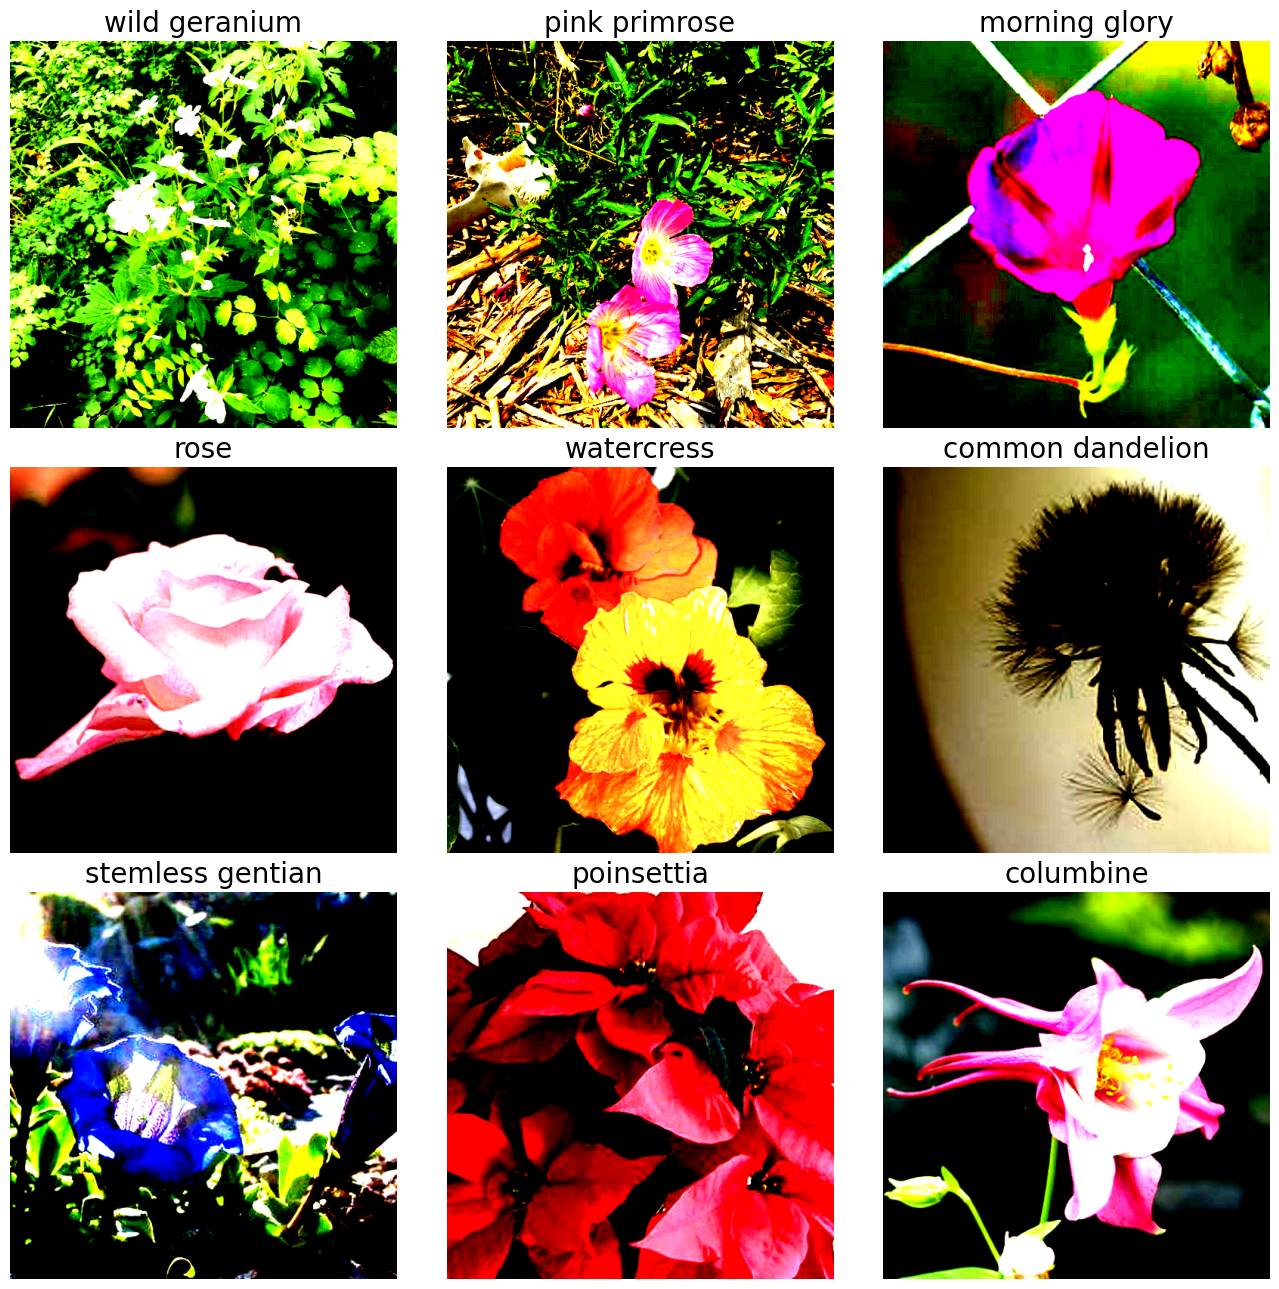

In [12]:
ds_iter = iter(df_train.unbatch().batch(10))
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

# Exploration of Data

In [13]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in df_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Training data label examples: [ 43  10  59 ...   4  95 102]


In [14]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in df_test.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Training data label examples: [b'2a0dc41cd' b'cbb2dd81a' b'9f6708c0b' ... b'2eb1d2313' b'246798d36'
 b'cd27460a9']


# Modeling

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output and add Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Replace with your actual image dimensions
input_shape = (512, 512, 3)
num_classes = len(CLASSES)  # Assuming CLASSES is a list of class labels

# Create the model
cnn_model = create_cnn_model(input_shape, num_classes)

# Display model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 128)       0

Learning rate schedule: 1e-05 to 5e-05 to 1.02e-05


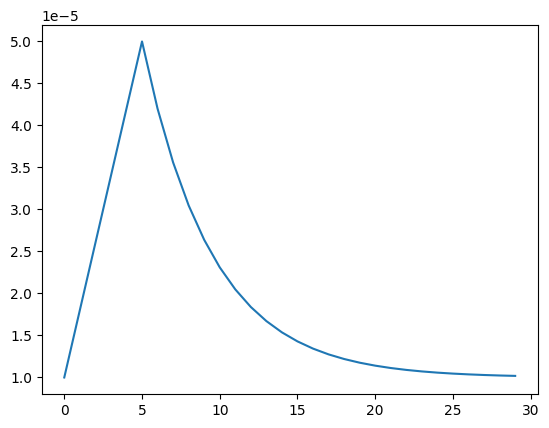

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
EPOCHS = 30
# Callback for early stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
import tensorflow as tf

# Define a generator function for preprocessing and training
def data_generator(dataset, batch_size, preprocess_function):
    for image, label in dataset.batch(batch_size):
        yield preprocess_function(image, label)

# Resize images to match the model's expected input shape
def preprocess_data(image, label):
    image = tf.image.resize(image, (512, 512))
    return image, label

# Create the model
model = create_cnn_model(input_shape=(512, 512, 3), num_classes=num_classes)

EPOCHS = 30
STEPS_PER_EPOCHS = NUM_TRAINING_IMAGES // BATCH_SIZE
CALLBACKS = [early_stopping_callback, lr_callback]

# Train the model using the generator
history = model.fit(data_generator(df_train, BATCH_SIZE, preprocess_data),
                    validation_data=data_generator(df_valid, BATCH_SIZE, preprocess_data),
                    steps_per_epoch=STEPS_PER_EPOCHS,
                    epochs=EPOCHS,
                    callbacks=CALLBACKS)

In [ ]:
# Resize test images to match the model's expected input shape
df_test_resized = df_test.map(preprocess_data)

# Create the model
model = create_cnn_model(input_shape=(512, 512, 3), num_classes=num_classes)

# Evaluate the model on the test dataset
evaluation_result = model.evaluate(df_test_resized)

# Print the evaluation result (typically includes loss and metrics)
print("Evaluation Result:", evaluation_result)